# Generating Randoms in Pixelated Masks

Explore algorithms to generate randoms in either flat healpix maps or multi-order maps
-----------------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from mocpy import MOC
import healpy as hp
from astropy.table import Table
import healsparse
from itertools import chain
from numba import njit, prange
import pandas as pd

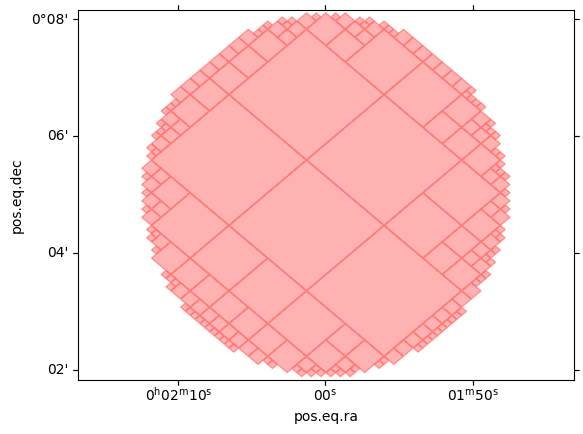

In [3]:
## Generate the cone we will be working with and plot it
cone = MOC.from_cone(30*u.arcmin, 5*u.arcmin, radius=3*u.arcmin, max_depth=15)
# Store also in pd.read_parquet('example_moc.parquet')

fig = plt.figure()
wcs = cone.wcs(fig)
ax = fig.add_subplot(projection=wcs)
cone.fill(ax, wcs, color='r', alpha=0.3)

In [3]:
cone

11/18524792-18524793 18524795-18524796 18524798 
12/74099147 74099150-74099151 74099162 74099177 74099179 74099525 74099536 
13/296396582-296396583 296396585-296396587 296396594-296396595 
 296396598-296396599 296396642 296396654 296396704-296396705 296396707 
 296396713 296396760 296396762 296396784 296396786 296396792 296398085 
 296398096-296398097 296398099 296398148-296398149 
14/1185586005 1185586007 1185586013 1185586015 1185586037 1185586039 1185586045 
 1185586047 1185586133 1185586319 1185586326-1185586327 1185586339 
 1185586370-1185586371 1185586374-1185586375 1185586386-1185586387 1185586390 
 1185586574 1185586608 1185586610-1185586611 1185586620 1185586622-1185586623 
 1185586824-1185586825 1185586827 1185586849 1185586860-1185586861 1185586863 
 1185587010 1185587016 1185587018-1185587019 1185587046 1185587052 1185587054 
 1185587140 1185587142 1185587148 1185587150 1185587172 1185587176-1185587178 
 1185592336-1185592337 1185592349 1185592392-1185592393 1185592395 
 11

# MOC case

In [20]:
@njit
def get_ho_pixel(ipix, order, poolord):
    """
    For pixel of a given order, retrieve at random one subpixel of higher order

    Parameters
    ----------
    pixel : int
        Pixel number
    order : int
        Order of pixel
    poolord : int
        Higher order at which to retrieve the random pixel
            
    Returns
    -------
    int
        Pixel number
    """
    scale_factor = 4**(poolord - order)
    return ipix * scale_factor + np.random.randint(0, scale_factor)

@njit(parallel=True)
def generate_subpixels(pxarray_rnd, ordarray_rnd, poolord):
    """
    For an array of input pixels and orders, generate a corresponding random (high order) 
    subpixel. Uses prange() of Numba to run in parallel.

    Parameters
    ----------
    pxarray_rnd : ndarray
        Pixel numbers
    ordarray_rnd : ndarray
        Pixel orders
    poolord : int
        Higher order at which to retrieve the random pixel
            
    Returns
    -------
    ndarray
        Pixel numbers (matching shape of pxarray_rnd) 
    """
    subpixels = np.zeros(pxarray_rnd.shape[0], dtype=np.int64)
    for i in prange(pxarray_rnd.shape[0]):
        subpixels[i] = get_ho_pixel(pxarray_rnd[i], ordarray_rnd[i], poolord)
    return subpixels

def makerans_moc(moc, nr=1000, columns=['pixnum','order']):
    """
    Generate randoms over a input MOC in either mocpy or dataframe format 

    Parameters
    ----------
    moc : MOC or dataFrame
        MOC map as ouput by mocpy or as pandas dataFrame 
    nr : int
        Number of randoms to generate
    columns : list of strings
        Colum name for the pixel number and order in the dataFrame 
            
    Returns
    -------
    ra_ndarray, dec_ndarray
        Coordinates of random points over the MOC 
    """
    poolord = 25     # order of subpixels to sample from
    
    # Check if we hava a pandas dataframe as input
    dff = False  #dataframe flag
    if 'pandas' in moc.__module__:
        import pandas as pd
        cpx, cor = columns
        dff = True

    if not(dff):
        smoc = moc.serialize(format='json')           # serialize to access orders and pixels
        maxord = moc.max_order                        # max order of the moc
        npixels = sum(len(v) for v in smoc.values())  # number of pixels of the MOC

        # Construct arrays of pixels, orders, and probabilities
        pixels = []
        orders = []
        probs = []
        for n, pixels_ordn in smoc.items():
            n = int(n)
            pixels.extend(pixels_ordn)
            orders.extend([n] * len(pixels_ordn))
            scalfac = 4**(maxord - n)  # scaling factor relative to max order
            probs.extend([scalfac] * len(pixels_ordn))
            
        # Convert lists to Numpy arrays
        pixels = np.array(pixels)
        orders = np.array(orders)
        probs = np.array(probs, dtype=np.float64)
    else:
        maxord = moc[cor].max()     # max order of the moc
        npixels = moc.shape[0]      # number of pixels of the MOC
        pixels = moc[cpx].values.astype('int64')
        orders = moc[cor].values.astype('int64')
        probs = 4**(maxord-moc[cor]).values.astype(np.float64)
    
    # Normalize probabilities
    probs /= probs.sum()

    # Random oversampling of the MOC pixels and their orders, following scaled probabilities
    # by the pixel areas respect to maxord
    rng = np.random.default_rng()
    idx = rng.choice(len(pixels), size=nr, replace=True, p=probs)
    pxarray_rnd = pixels[idx]
    ordarray_rnd = orders[idx]

    # Use Numba to generate high-order subpixels
    subpixels = generate_subpixels(pxarray_rnd, ordarray_rnd, poolord)

    # Convert subpixels to angles
    ras, decs = hp.pix2ang(2**poolord, subpixels, nest=True, lonlat=True)
    
    print('MOC order        :', maxord)
    print('Nr. of MOC pixels:', npixels)
    print('Randoms generated:', len(ras))
    return ras, decs

In [7]:
%%time
qq,pp = makerans_moc(cone, nr=250_000, columns=['numpix','order'])

MOC order        : 15
Nr. of MOC pixels: 203
Randoms generated: 250000
CPU times: user 27.5 ms, sys: 3.72 ms, total: 31.2 ms
Wall time: 21 ms


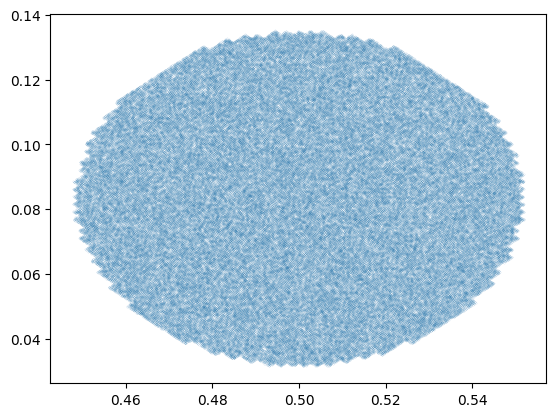

In [8]:
plt.scatter(qq,pp,s=0.002)

In [436]:
Table(np.vstack([qq,pp]).T, names=['ra','dec']).write('xxx.fits', overwrite=True)

In [3]:
import lsdb
from pathlib import Path
HIPSCAT_DIR = Path('/home/edonoso/Downloads/elzorro/hipscat/')
HIPSCAT_NAME = 'hsc_pdr3_mask_i'  # bright star masks for HSC PDR3 I-band

In [4]:
catalog = lsdb.read_hipscat(HIPSCAT_DIR / HIPSCAT_NAME).compute()

In [7]:
cato = catalog.query('value==0')[['pixel_Norder', 'pixel_Npix', 'value']]

In [8]:
qq,pp = makerans_moc_numba(cato, nr=50_000_000, columns=['pixel_Npix','pixel_Norder'])

MOC order        : 15
Nr. of MOC pixels: 47010388
Randoms generated: 50000000


In [9]:
Table(np.vstack([qq,pp]).T, names=['ra','dec']).write('xxx-00-nada.fits', overwrite=True)

# Flat pixel list

In [13]:
@njit
def get_ho_pixel(ipix, order, poolord):
    """
    For pixel of a given order, retrieve at random one subpixel of higher order

    Parameters
    ----------
    pixel : int
        Pixel number
    order : int
        Order of pixel
    poolord : int
        Higher order at which to retrieve the random pixel
            
    Returns
    -------
    int
        Pixel number
    """
    scale_factor = 4**(poolord - order)
    return ipix * scale_factor + np.random.randint(0, scale_factor)

@njit(parallel=True)
def generate_subpixels(pxarray_rnd, order, poolord):
    """
    For an array of input pixels and orders, generate a corresponding random (high order) 
    subpixel. Uses prange() of Numba to run in parallel.

    Parameters
    ----------
    pxarray_rnd : ndarray
        Pixel numbers
    order : integer
        Order of the input pixels
    poolord : int
        Higher order at which to retrieve the random pixel
            
    Returns
    -------
    ndarray
        Pixel numbers (matching shape of pxarray_rnd) 
    """
    subpixels = np.zeros(pxarray_rnd.shape[0], dtype=np.int64)
    for i in prange(pxarray_rnd.shape[0]):
        subpixels[i] = get_ho_pixel(pxarray_rnd[i], order, poolord)
    return subpixels

def makerans(pxs, order, nr=1000):
    """
    Generate randoms over a set of helpix pixels of a given order 

    Parameters
    ----------
    psx : ndarray
        Pixels  
    order : int
        Order of pixels
    nr : int
        Desired number of randoms 
            
    Returns
    -------
    ra_ndarray, dec_ndarray
        Coordinates of random points over the pixels 
    """
    poolord = 25            # order of subpixels to sample from
    npixels = pxs.shape[0]  # number of pixels of the MOC

    # Random oversampling of the input pixels
    rng = np.random.default_rng()
    pxarray_rnd = rng.choice(pxs, size=nr, replace=True)

    # Use Numba to generate high-order subpixels
    subpixels = generate_subpixels(pxarray_rnd, order, poolord)

    # Convert subpixels to angles
    ras, decs = hp.pix2ang(2**poolord, subpixels, nest=True, lonlat=True)
    
    print('Input order         :', order)
    print('Nr. of input pixels :', npixels)
    print('Randoms generated   :', len(ras))
    return ras, decs

In [19]:
%%time
xx, yy = makerans(cone.flatten(), 15, nr=100_000_000)

Input order         : 15
Nr. of input pixels : 2573
Randoms generated   : 100000000
CPU times: user 2.6 s, sys: 933 ms, total: 3.54 s
Wall time: 1.97 s


In [24]:
%%time
qq,pp = makerans_moc(cone, nr=100_000_000)

MOC order        : 15
Nr. of MOC pixels: 203
Randoms generated: 100000000
CPU times: user 5.04 s, sys: 1.13 s, total: 6.17 s
Wall time: 4.45 s


# Now generate rands over el_Zorro masks

In [3]:
import lsdb
from pathlib import Path
HIPSCAT_DIR = Path('/home/edonoso/Downloads/elzorro/hipscat/')
HIPSCAT_NAME = 'hsc_pdr3_mask_i'  # bright star masks for HSC PDR3 I-band

In [4]:
catalog = lsdb.read_hipscat(HIPSCAT_DIR / HIPSCAT_NAME).compute()

In [7]:
cato = catalog.query('value==0')[['pixel_Norder', 'pixel_Npix', 'value']]

In [8]:
qq,pp = makerans_moc_numba(cato, nr=50_000_000, columns=['pixel_Npix','pixel_Norder'])

MOC order        : 15
Nr. of MOC pixels: 47010388
Randoms generated: 50000000


In [9]:
Table(np.vstack([qq,pp]).T, names=['ra','dec']).write('xxx-00-nada.fits', overwrite=True)

# Drafts

## Try randoms with a single cone - flat case

In [5]:
def get_higher_order_pixels(pixel_N, order_N, target_order):
    """Get the subpixels of high order (target_order) inside a pixel of a given order (order_N)"""
    #------------------------
    #Example usage
    #pixel_N = 19923020   # Given pixel index at order N
    #order_N = 11         # Original order
    #target_order = 12    # Higher order to get the pixels for
    #higher_order_pixels = get_higher_order_pixels(pixel_N, order_N, target_order)
    
    scaling_factor = 4 ** (target_order - order_N)
    # Calculate the starting and ending pixel indices at the higher order
    start_pixel = pixel_N * scaling_factor
    end_pixel = start_pixel + scaling_factor - 1
    
    # Return the range of pixels at the higher order
    return list(range(start_pixel, end_pixel + 1))

In [5]:
def rands_in_flatmoc(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # First flatten the input moc to its highest order and generate a constant fraction of the desired
    # randoms in each pixel, by random subsamling among the subpixels very high order. 
    # Warning!!! This seems to introduce uniformity instead of randomness
    
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    mocf = moc.flatten().astype('int')
    
    npixels = len(mocf)
    nr_per_pix = int(np.ceil(nr/npixels))
    print('Randoms per pixel = ', nr_per_pix)

    print('Pixel pool order =', poolord)
    print('Pixel pool size =', len(get_higher_order_pixels(mocf[0], maxord, poolord)))
    
    result = np.zeros(npixels*nr_per_pix, dtype='int64')
    
    for i,ipix in enumerate(mocf):
        #print(ipix)
        pixpool = get_higher_order_pixels(ipix, maxord, poolord)
        subpxs = np.random.choice(pixpool, nr_per_pix)
        result[i*nr_per_pix : (i+1)*nr_per_pix] = subpxs

    # Shuffle indexes first and then cut out the few extra indexes that enter due to rounding
    # the fraction to the upper integer
    rng = np.random.default_rng()
    rng.shuffle(result)
    nr_effective = result.shape[0]
    print('nreff=', nr_effective)
    if nr_effective > nr:  result = result[:nr]

    # Convert to angles
    ras, decs = hp.pix2ang(2**poolord, result, nest=True, lonlat=True)

    print('nran returned:', ras.shape[0])
    return ras, decs

In [6]:
xx, yy = rands_in_flatmoc(cone, nr=50000)

Randoms per pixel =  20
Pixel pool order = 22
Pixel pool size = 16384
nreff= 51900
nran returned: 50000


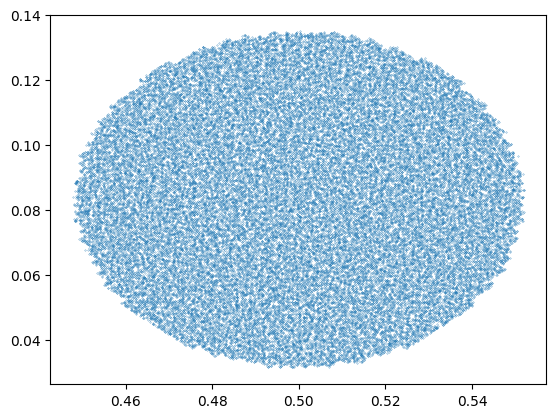

In [7]:
plt.scatter(xx, yy, s=0.05)

## Try randoms with a single cone - moc case

In [8]:
def shuffle_arrays(arrays, set_seed=-1):
    """Shuffles arrays in-place, in the same order, along axis=0

    arrays : Llist of numpy arrays
    set_seed : Seed value if int >= 0, else seed is random
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [9]:
def rands_in_moc(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # This actually uses the moc without flattening. As, before, randoms are generated from the subpixels
    # of very high orders, but this time the fraction of randoms in each pixel is adjusted by its area. 
    # Warning!!! Looks better, but again, there is somee uniformity, as for example, all pixels of order
    # lets say 15 of the moc will have exactly the same number of randoms.
    
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    smoc = cone.serialize(format='json')  #serialize to acces orders and pixels

    # Get the number of pixels of the moc
    npixels = sum(map(len, smoc.values()))
    print('npixels in moc', npixels)

    # Calculate the number of pixels that a flattened moc would have
    npixels_maxord = 0
    for key in smoc:
        n = int(key)
        npixels_maxord = npixels_maxord + 4**(maxord-n)*len(smoc[key])
    print('npixels at maxord:', npixels_maxord)

    # Estimate the fraction of rands per pixel that the flattened moc would require
    nrperpix_maxord = int(np.ceil(nr/npixels_maxord))
    print('nrand per pixel at maxord:', nrperpix_maxord)

    # Iterate for each order and pixels of that order, getting the list of subpixels
    # and choosing randomly the fraction of points adjusted by the 4^(maxord-n), i.e.
    # the ratios of the areas of those pixels
    ras = []
    decs = []
    for key in smoc:
        #print(key)
        n = int(key)
        subpxs = np.array(smoc[key])
        for i,ipix in enumerate(subpxs):
            #print(key, ipix)
            pixpool = get_higher_order_pixels(ipix, n, poolord)
            nr_thispix = nrperpix_maxord*4**(maxord-n)
            #print('nr_thispix =',nr_thispix)
            #print(key, ipix, len(pixpool), nr_thispix)
            subpxs2 = np.random.choice(pixpool, nr_thispix)
            iras, idecs = hp.pix2ang(2**poolord, subpxs2, nest=True, lonlat=True)
            ras.append(iras)
            decs.append(idecs)

    ras = np.concatenate([x.ravel() for x in ras])
    decs = np.concatenate([x.ravel() for x in decs])

    # Shuffle indexes first and then cut out the few extra indexes that enter due to rounding
    # the fraction to the upper integer
    shuffle_arrays([ras, decs])
    nr_effective = ras.shape[0]
    print('nreff=', nr_effective)
    if nr_effective > nr:
        ras = ras[:nr]
        decs = decs[:nr]
        
    print('nran returned:', ras.shape[0])
    return ras, decs

In [10]:
ii, jj = rands_in_moc(cone,50000)

npixels in moc 222
npixels at maxord: 2595
nrand per pixel at maxord: 20
nreff= 51900
nran returned: 50000


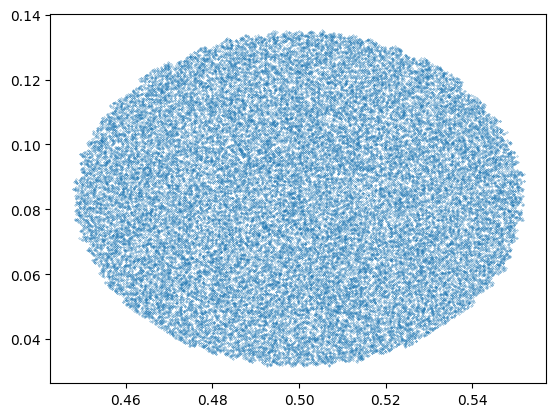

In [11]:
plt.scatter(ii, jj, s=0.05)

## Now compare both versions, flat and with moc

In [12]:
xx, yy = rands_in_flatmoc(cone, nr=250000)
ii, jj = rands_in_moc(cone, nr=250000)

Randoms per pixel =  97
Pixel pool order = 22
Pixel pool size = 16384
nreff= 251715
nran returned: 250000
npixels in moc 222
npixels at maxord: 2595
nrand per pixel at maxord: 97
nreff= 251715
nran returned: 250000


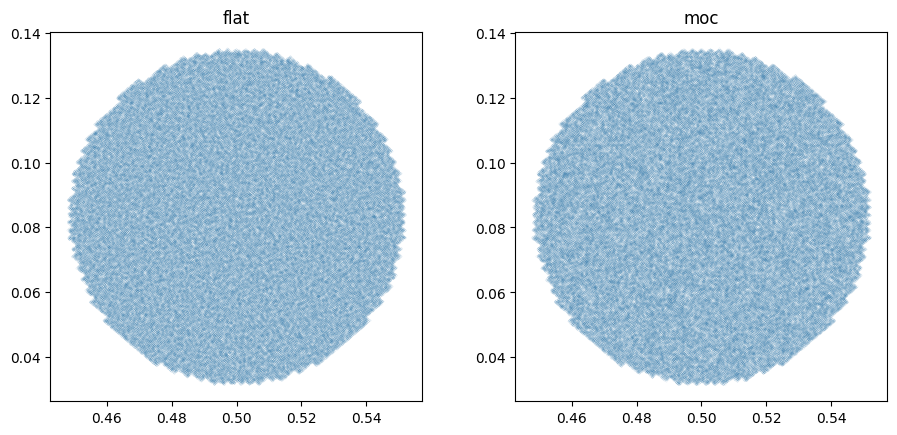

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ps = 0.001  # point size
ax1.scatter(xx, yy, s=ps);  ax1.set_title('flat');  ax1.set_aspect(1)
ax2.scatter(ii, jj, s=ps);  ax2.set_title('moc');  ax2.set_aspect(1)
fig.set_figwidth(11)

In [541]:
# Save to file to explore with topcat
Table(np.vstack([xx,yy]).T, names=['ra','dec']).write('ran_flat.fits')
Table(np.vstack([ii,jj]).T, names=['ra','dec']).write('ran_moc.fits')

## Try randoms with single cone - healsparse

In [14]:
circ = healsparse.Circle(ra=0.5, dec=5./60, radius=3./60., value=1)
smap = circ.get_map(nside_coverage=32, nside_sparse=2**15, dtype=np.int16)
ra_rand, dec_rand = healsparse.make_uniform_randoms_fast(smap, 250_000)

# Save to file to explore with topcat
#Table(np.vstack([ra_rand,dec_rand]).T, names=['ra','dec']).write('ran_healsp.fits')

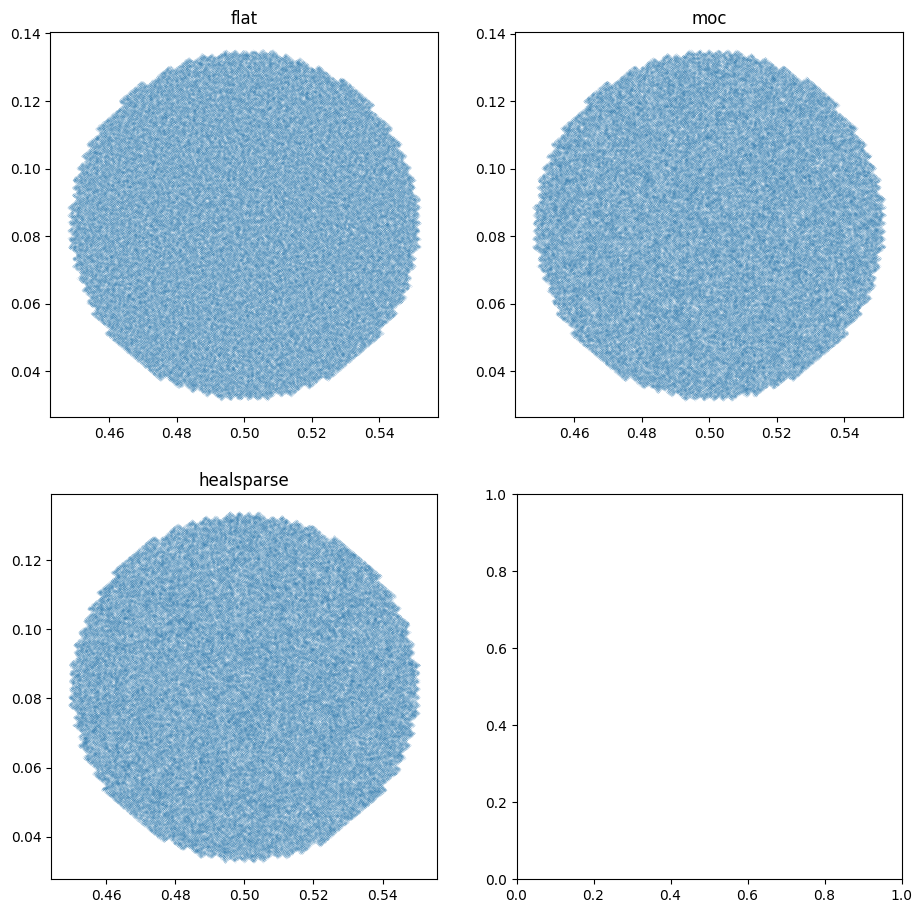

In [15]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)
ps = 0.002  #point size
ax1.scatter(xx, yy, s=ps);  ax1.set_title('flat');  ax1.set_aspect(1)
ax2.scatter(ii, jj, s=ps);  ax2.set_title('moc');  ax2.set_aspect(1)
ax3.scatter(ra_rand, dec_rand, s=ps);  ax3.set_title('healsparse');  ax3.set_aspect(1) 
ax4.set_aspect(1)
fig.set_figwidth(11);  fig.set_figheight(11)

**The moc version looks similar as healsparse and definitely the flat case is not random**

## Try randoms with a single cone - flat case - use hpgeom to pixelate

In [6]:
import hpgeom as hpgeo
hpcirc = hpgeo.query_circle(2**15, 0.5, 5./60, 3./60, inclusive=False, fact=4, nest=True, lonlat=True, degrees=True)

In [7]:
def rands_in_flatmoc(moc, nr=1000):
    poolord = 22
    maxord = 15
    mocf = moc.astype('int')
    
    npixels = len(mocf)
    nr_per_pix = int(np.ceil(nr/npixels))
    print('Randoms per pixel = ', nr_per_pix)

    print('Pixel pool order =', poolord)
    print('Pixel pool size =', len(get_higher_order_pixels(mocf[0], maxord, poolord)))
    
    result = np.zeros(npixels*nr_per_pix, dtype='int64')
    
    for i,ipix in enumerate(mocf):
        #print(ipix)
        pixpool = get_higher_order_pixels(ipix, maxord, poolord)
        subpxs = np.random.choice(pixpool, nr_per_pix)
        result[i*nr_per_pix : (i+1)*nr_per_pix] = subpxs

    rng = np.random.default_rng()
    rng.shuffle(result)
    
    nr_effective = result.shape[0]
    print('nreff=', nr_effective)
    if nr_effective > nr:  result = result[:nr]
    
    ras, decs = hp.pix2ang(2**poolord, result, nest=True, lonlat=True)

    print('nran returned:', ras.shape[0])
    return ras, decs

In [8]:
xx, yy = rands_in_flatmoc(hpcirc, nr=250000)

Randoms per pixel =  102
Pixel pool order = 22
Pixel pool size = 16384
nreff= 250410
nran returned: 250000


In [10]:
Table(np.vstack([xx,yy]).T, names=['ra','dec']).write('ran_hpgeom.fits', overwrite=True)

## 2dn try flat : use double random

In [105]:
def rands_in_flatmoc2(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # First flatten the input moc to its highest order but this time choice randomly among its pixels
    # the total number of desired randoms, and for each choose at random ONE of its subpixels as the 
    # accepted rnd position. 
    # This seems to get rid of uniformity but it is very very slow !!!!
    
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    mocf = moc.flatten().astype('int')
    
    npixels = len(mocf)
    nr_per_pix = int(np.ceil(nr/npixels))
    print('Randoms per pixel = ', nr_per_pix)

    print('Pixel pool order =', poolord)
    print('Pixel pool size =', len(get_higher_order_pixels(mocf[0], maxord, poolord)))

    # random oversampling of the flattened moc pixels
    mocfr = np.random.choice(mocf, size=nr, replace=True)

    result = np.empty(0, dtype=int)    
    for i,ipix in enumerate(mocfr):
        if np.mod(i,10000)==0: print(i)
        #print(ipix)
        pixpool = get_higher_order_pixels(ipix, maxord, poolord)
        subpxs = np.random.choice(pixpool, 1)  # Choose only one subpixel
        result = np.concatenate([result, subpxs])

    ras, decs = hp.pix2ang(2**poolord, result, nest=True, lonlat=True)

    print('nran returned:', ras.shape[0])
    return ras, decs

In [106]:
a, b = rands_in_flatmoc2(cone, nr=250000)

Randoms per pixel =  98
Pixel pool order = 22
Pixel pool size = 16384
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
nran returned: 250000


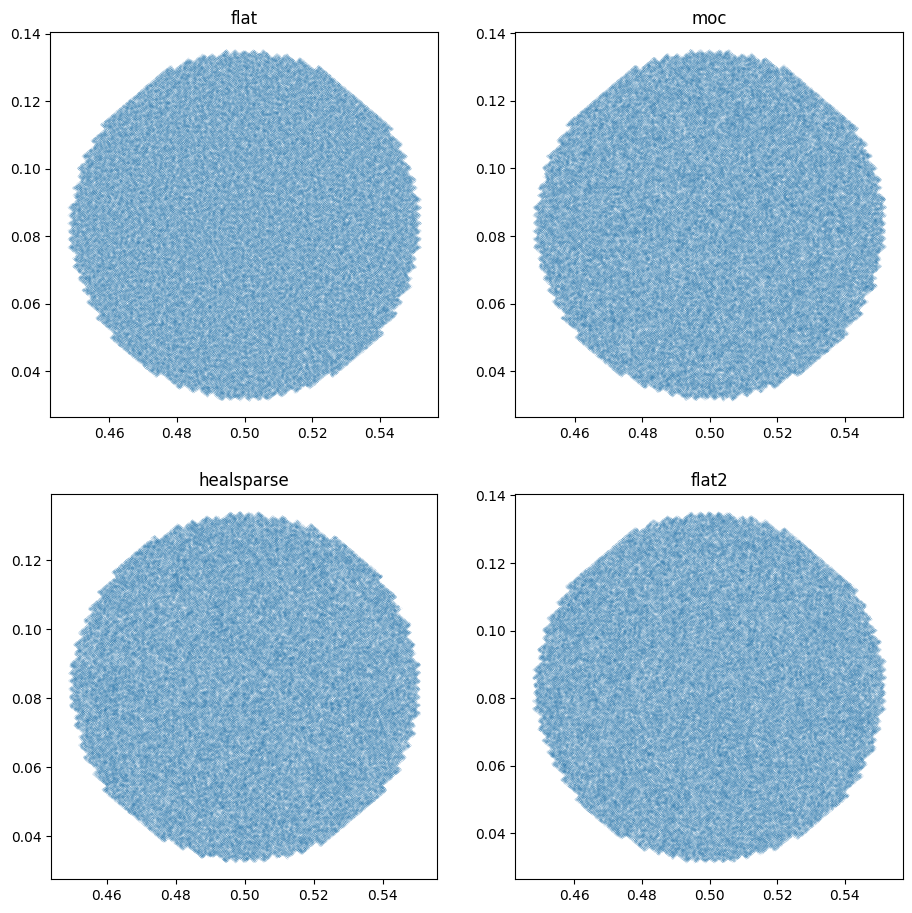

In [108]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)
ps = 0.002  #point size
ax1.scatter(xx, yy, s=ps);  ax1.set_title('flat');  ax1.set_aspect(1)
ax2.scatter(ii, jj, s=ps);  ax2.set_title('moc');  ax2.set_aspect(1)
ax3.scatter(ra_rand, dec_rand, s=ps);  ax3.set_title('healsparse');  ax3.set_aspect(1) 
ax4.scatter(a, b, s=ps);  ax4.set_title('flat2'); ax4.set_aspect(1)
fig.set_figwidth(11);  fig.set_figheight(11)

In [109]:
# Save to file to explore with topcat
Table(np.vstack([a,b]).T, names=['ra','dec']).write('ran_flat2.fits')

In [113]:
xx, yy = rands_in_flatmoc(cone, nr=250000)

Randoms per pixel =  97
Pixel pool order = 22
Pixel pool size = 16384
nreff= 251715
nran returned: 250000


In [115]:
Table(np.vstack([xx,yy]).T, names=['ra','dec']).write('ran_flat_ddepth0.fits')

## 3rd try flat : use double random with hpgeom and optimizations

In [12]:
import hpgeom as hpgeo
hpcirc = hpgeo.query_circle(2**15, 0.5, 5./60, 3./60, inclusive=False, fact=4, nest=True, lonlat=True, degrees=True)

In [33]:
def get_ho_pixel(pixel_N, order_N, target_order):
    """Get only one subpixef of high order (target_order) inside a pixel of a given order (order_N)"""
    
    scaling_factor = 4 ** (target_order - order_N)
    # Calculate the starting and ending pixel indices at the higher order
    start_pixel = pixel_N * scaling_factor
    end_pixel = start_pixel + scaling_factor - 1
    
    # Return one random pixel at the higher order
    return np.random.randint(start_pixel, high=end_pixel)

In [54]:
def rands_in_flatmoc3(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # Same as before but switched to hpgeom pixelization in order to match healsparse
    #
    # First flatten the input moc to its highest order but this time choice randomly among its pixels
    # the total number of desired randoms, and for each choose at random ONE of its subpixels as the 
    # accepted rnd position. 
    # This seems to get rid of uniformity but it is very very slow !!!!
    
    poolord = 22            # order of subpixels to sample from
    maxord  = 15
    mocf = moc.astype('int')

    print('Pixel pool order =', poolord)
    print('Pixel pool size =', len(get_higher_order_pixels(mocf[0], maxord, poolord)))

    # random oversampling of the flattened moc pixels
    mocfr = np.random.choice(mocf, size=nr, replace=True)

    subpixels = np.zeros_like(mocfr)
    for i,ipix in enumerate(mocfr):
        #if np.mod(i,10000)==0: print(i)
        #print(ipix)
        subpixels[i] = get_ho_pixel(ipix, maxord, poolord)

    ras, decs = hp.pix2ang(2**poolord, subpixels, nest=True, lonlat=True)

    print('nran returned:', ras.shape[0])
    return ras, decs

In [55]:
xx, yy = rands_in_flatmoc3(hpcirc, nr=250_000)

Pixel pool order = 22
Pixel pool size = 16384
nran returned: 250000


In [47]:
Table(np.vstack([xx,yy]).T, names=['ra','dec']).write('ran_flat2_hpgeom_opt.fits', overwrite=True)

## 3rd try moc : use double random with mocpy and optimizations

In [70]:
p1 = np.array([1.,4.,16.,1.,1.,1.,1.,1.,1.,1.])

In [71]:
p2 = p1/sum(p1)

In [74]:
p2

array([0.03571429, 0.14285714, 0.57142857, 0.03571429, 0.03571429,
       0.03571429, 0.03571429, 0.03571429, 0.03571429, 0.03571429])

In [76]:
np.random.choice([0,1,2,3,4,5,6,7,8,9], size=20, p=p2)

array([2, 1, 2, 1, 6, 5, 2, 2, 2, 1, 4, 2, 1, 3, 2, 7, 2, 2, 6, 7])

In [219]:
def rands_in_moc3(moc, nr=1000):
    """Generate randoms for a input MOC"""
    ##################################
    # This actually uses the moc without flattening
    
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    smoc = cone.serialize(format='json')  #serialize to acces orders and pixels

    # Get the number of pixels of the moc
    npixels = sum(map(len, smoc.values()))
    print('npixels in moc', npixels)

    pixlist = []
    problist = []
    for key in smoc:
        #print(key)
        n = int(key)
        pixels = smoc[key]
        order = [n]*len(pixels)
        prob_order = 4**(maxord-n)
        problist.append([prob_order]*len(pixels))
        pixlist.append(list(zip(pixels,order)))

    pixlist = list(chain(*pixlist))  # flatten one level
    
    normfac = 1./sum(list(map(sum,problist)))
    problist = list(chain(*problist))
    probarr = np.array([i*normfac for i in problist])  # array of probabilities

    pxarray = np.array([i[0] for i in pixlist])
    ordarray = np.array([i[1] for i in pixlist])
    
    # random oversampling of the flattened moc pixels
    rng = np.random.default_rng(8080)
    pxarray_rnd = rng.choice(pxarray, size=nr, replace=True, p=probarr)
    rng = np.random.default_rng(8080)
    ordarray_rnd = rng.choice(ordarray, size=nr, replace=True, p=probarr)

    subpixels = np.zeros_like(pxarray_rnd)
    for i,ipix in enumerate(pxarray_rnd):
        #if np.mod(i,10000)==0: print(i)
        #print(ipix)
        subpixels[i] = get_ho_pixel(ipix, ordarray_rnd[i], poolord)

    ras, decs = hp.pix2ang(2**poolord, subpixels, nest=True, lonlat=True)
    
    return ras, decs

In [221]:
qq,pp = rands_in_moc3(cone, nr=250_000)

npixels in moc 222


In [215]:
Table(np.vstack([qq,pp]).T, names=['ra','dec']).write('ran_moc3_opt.fits', overwrite=True)

## Working MOC case - prefinal polishing

In [233]:
def get_ho_pixel(pixel, order, high_order):
    """
    For pixel of a given order, retrieve at random one subpixel of higher order

    Parameters
    ----------
    pixel : int
        Pixel number
    order : int
        Order of pixel
    high_order : int
        Order at which to retrieve the random pixel
            
    Returns
    -------
    int
        Pixel number
    """
    
    scaling_ratio = 4 ** (high_order - order)
    # Calculate the starting and ending pixel indices at the higher order
    start_pixel = pixel * scaling_ratio
    end_pixel = start_pixel + scaling_ratio - 1
    
    # Return one random pixel at the higher order
    return np.random.randint(start_pixel, high=end_pixel)

In [282]:
def makerans_moc(moc, nr=1000):
    """
    Generate randoms for a input MOC
    """
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    smoc = cone.serialize(format='json')  #serialize to access orders and pixels

    # Get the number of pixels of the moc. Just informative
    npixels = sum(map(len, smoc.values()))
    print('MOC order        :', maxord)
    print('Nr. of MOC pixels:', npixels)

    # Construct lists of pixels, orders and probabilities
    pixels = []
    orders = []
    probs = []
    for key in smoc:
        #print(key)
        n = int(key)
        pixels_ordn = smoc[key]
        order_ordn = [n]*len(pixels_ordn)
        pixels.append(pixels_ordn)
        orders.append(order_ordn)
        scalfac = 4**(maxord-n)  #scaling factor respect to maxorder
        probs.append([scalfac]*len(pixels_ordn))

    # Flatten lists one level
    pixels = np.array(list(chain(*pixels)))
    orders = np.array(list(chain(*orders)))
    
    # Normalize probabilities
    normfac = 1./sum(list(map(sum,probs)))
    probs = list(chain(*probs))
    probs = np.array([i*normfac for i in probs])
    
    # Random oversampling of the MOC pixels in unison with its orders, but following
    # probabilities scaled by the sizes of pixels at different orders
    rng = np.random.default_rng(8080)
    pxarray_rnd = rng.choice(pixels, size=nr, replace=True, p=probs)
    rng = np.random.default_rng(8080)
    ordarray_rnd = rng.choice(orders, size=nr, replace=True, p=probs)

    # For every randomized MOC pixel, get a single random high order subpixel
    subpixels = np.zeros_like(pxarray_rnd)
    for i,ipix in enumerate(pxarray_rnd):
        subpixels[i] = get_ho_pixel(ipix, ordarray_rnd[i], poolord)
        
    # We could replace the for loop above with map(). Performance is similar though.
    #subpixels = np.array(list(map(lambda x: get_ho_pixel(x[0], x[1], poolord), zip(pxarray_rnd, ordarray_rnd))))
    
    # Convert pixels to angles
    ras, decs = hp.pix2ang(2**poolord, subpixels, nest=True, lonlat=True)
    print('Randoms generated:',len(ras))
    return ras, decs

In [285]:
%%time
qq,pp = makerans_moc(cone, nr=25_000_000)

MOC order        : 15
Nr. of MOC pixels: 222
Randoms generated: 25000000
CPU times: user 33.3 s, sys: 270 ms, total: 33.6 s
Wall time: 33.6 s


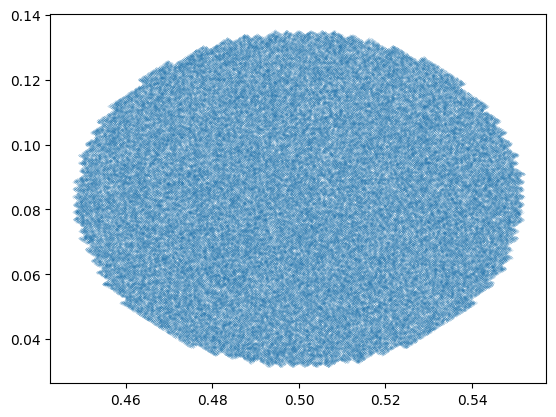

In [280]:
plt.scatter(qq,pp,s=0.005)

In [292]:
import numpy as np
from itertools import chain

def makerans_moc_optim(moc, nr=1000):
    """
    Generate randoms for an input MOC.
    """
    poolord = 22            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    smoc = moc.serialize(format='json')  # serialize to access orders and pixels

    # Get the number of pixels of the MOC
    npixels = sum(len(v) for v in smoc.values())
    print('MOC order        :', maxord)
    print('Nr. of MOC pixels:', npixels)

    # Construct arrays of pixels, orders, and probabilities
    pixels = []
    orders = []
    probs = []

    for n, pixels_ordn in smoc.items():
        n = int(n)
        pixels.extend(pixels_ordn)
        orders.extend([n] * len(pixels_ordn))
        scalfac = 4**(maxord - n)  # scaling factor relative to max order
        probs.extend([scalfac] * len(pixels_ordn))

    # Convert lists to Numpy arrays
    pixels = np.array(pixels)
    orders = np.array(orders)
    probs = np.array(probs, dtype=np.float64)

    # Normalize probabilities
    probs /= probs.sum()

    # Random oversampling of the MOC pixels and their orders, following scaled probabilities
    rng = np.random.default_rng(8080)
    idx = rng.choice(len(pixels), size=nr, replace=True, p=probs)

    pxarray_rnd = pixels[idx]
    ordarray_rnd = orders[idx]

    # Get high order subpixels using vectorized operations
    subpixels = np.array([get_ho_pixel(px, ord, poolord) for px, ord in zip(pxarray_rnd, ordarray_rnd)])

    # Convert pixels to angles
    ras, decs = hp.pix2ang(2**poolord, subpixels, nest=True, lonlat=True)
    print('Randoms generated:', len(ras))

    return ras, decs


In [291]:
%%time
qq,pp = makerans_moc_optim(cone, nr=25_000_000)

MOC order        : 15
Nr. of MOC pixels: 222
Randoms generated: 25000000
CPU times: user 33.2 s, sys: 488 ms, total: 33.6 s
Wall time: 33.6 s


In [454]:
@njit
def get_ho_pixel(ipix, order, poolord):
    """
    For a pixel at certain order, retrieve at random one subpixel of higher order

    Parameters
    ----------
    pixel : int
        Pixel number
    order : int
        Order of pixel
    high_order : int
        Order at which to retrieve the random pixel
            
    Returns
    -------
    int
        Pixel number
    """
    scale_factor = 4**(poolord - order)
    return ipix * scale_factor + np.random.randint(0, scale_factor)

@njit(parallel=True)
def generate_subpixels(pxarray_rnd, ordarray_rnd, poolord):
    """
    Numba-optimized function to generate subpixels in parallel.
    """
    subpixels = np.zeros(pxarray_rnd.shape[0], dtype=np.int64)
    for i in prange(pxarray_rnd.shape[0]):
        subpixels[i] = get_ho_pixel(pxarray_rnd[i], ordarray_rnd[i], poolord)
    return subpixels

def makerans_moc(moc, nr=1000):
    """
    Generate randoms for an input MOC.
    """
    poolord = 25            # order of subpixels to sample from
    maxord = moc.max_order  # max order of the moc
    smoc = moc.serialize(format='json')  # serialize to access orders and pixels

    # Get the number of pixels of the MOC
    npixels = sum(len(v) for v in smoc.values())
    print('MOC order        :', maxord)
    print('Nr. of MOC pixels:', npixels)

    # Construct arrays of pixels, orders, and probabilities
    pixels = []
    orders = []
    probs = []

    for n, pixels_ordn in smoc.items():
        n = int(n)
        pixels.extend(pixels_ordn)
        orders.extend([n] * len(pixels_ordn))
        scalfac = 4**(maxord - n)  # scaling factor relative to max order
        probs.extend([scalfac] * len(pixels_ordn))

    # Convert lists to Numpy arrays
    pixels = np.array(pixels)
    orders = np.array(orders)
    probs = np.array(probs, dtype=np.float64)

    # Normalize probabilities
    probs /= probs.sum()

    # Random oversampling of the MOC pixels and their orders, following scaled probabilities
    rng = np.random.default_rng(8080)
    idx = rng.choice(len(pixels), size=nr, replace=True, p=probs)

    pxarray_rnd = pixels[idx]
    ordarray_rnd = orders[idx]

    # Use Numba to generate high-order subpixels
    subpixels = generate_subpixels(pxarray_rnd, ordarray_rnd, poolord)

    # Convert pixels to angles
    ras, decs = hp.pix2ang(2**poolord, subpixels, nest=True, lonlat=True)
    print('Randoms generated:', len(ras))

    return ras, decs, pixels, orders


In [459]:
%%time
qq,pp,pixels,orders = makerans_moc(cone, nr=250_000)

MOC order        : 15
Nr. of MOC pixels: 222
Randoms generated: 250000
CPU times: user 166 ms, sys: 753 μs, total: 167 ms
Wall time: 23.3 ms


In [453]:
pp

array([0.09475867, 0.0740165 , 0.08163445, ..., 0.07490557, 0.06228678,
       0.08228446])